# IMPORT LIBRARIES/DATASETS

In [10]:
# import the necessary packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.layers import *
from keras.models import Model
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [11]:
from utils.data_generators import train_generator, validation_generator, test_generator
from utils.globals import categorical_labels

labels = categorical_labels


In [12]:
# load the inception resnetv2 model
basemodel = InceptionResNetV2(
    weights='imagenet',
    include_top=False,
    input_tensor=Input(shape=(256, 256, 3))
)

# Freeze the basemodel weights , so these weights won't change during training
basemodel.trainable = True

In [13]:
# print the model summary
basemodel.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_203 (Conv2D)            (None, 127, 127, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_203 (Batch  (None, 127, 127, 32  96         ['conv2d_203[0][0]']             
 Normalization)                 )                                               

In [14]:
# Add classification head to the model

headmodel = basemodel.output
headmodel = GlobalAveragePooling2D(name = 'global_average_pool')(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu", name = 'dense_1')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation = "relu", name = 'dense_2')(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(3, activation = 'softmax', name = 'dense_3')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [15]:
# print the model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_203 (Conv2D)            (None, 127, 127, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_203 (Batch  (None, 127, 127, 32  96         ['conv2d_203[0][0]']             
 Normalization)                 )                                                           

In [16]:
# compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=SGD(lr=.0001, momentum=.9),
    metrics=["accuracy"]
)



In [17]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(
    monitor='val_loss',
    mode='min',
    verbose=1,
    patience=20
)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(
    filepath="weights/InceptionResNetV2_trainable.hdf5",
    verbose=1,
    save_best_only=True
)


In [18]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // 32,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // 32,
    callbacks=[checkpointer, earlystopping]
)


Epoch 1/10
28/28 [==============================] - ETA: 0s - loss: 1.1781 - accuracy: 0.2763 
Epoch 1: val_loss improved from inf to 1.12663, saving model to weights/InceptionResNetV2_trainable.hdf5
28/28 [==============================] - 857s 29s/step - loss: 1.1781 - accuracy: 0.2763 - val_loss: 1.1266 - val_accuracy: 0.3854
Epoch 2/10
28/28 [==============================] - ETA: 0s - loss: 1.0850 - accuracy: 0.4088 
Epoch 2: val_loss improved from 1.12663 to 1.00772, saving model to weights/InceptionResNetV2_trainable.hdf5
28/28 [==============================] - 778s 28s/step - loss: 1.0850 - accuracy: 0.4088 - val_loss: 1.0077 - val_accuracy: 0.5104
Epoch 3/10
28/28 [==============================] - ETA: 0s - loss: 1.0678 - accuracy: 0.4326 
Epoch 3: val_loss improved from 1.00772 to 0.97409, saving model to weights/InceptionResNetV2_trainable.hdf5
28/28 [==============================] - 677s 24s/step - loss: 1.0678 - accuracy: 0.4326 - val_loss: 0.9741 - val_accuracy: 0.5833

In [19]:
model.save('models/InceptionResNetV2_trainable.h5')

In [20]:
# Evaluate the performance of the model
evaluate = model.evaluate(
    test_generator,
    steps=test_generator.n // 32,
    verbose=1
)

print('Accuracy Test : {}'.format(evaluate[1]))


3/3 [==============================] - 6s 2s/step - loss: 0.9013 - accuracy: 0.5208
Accuracy Test : 0.5208333134651184


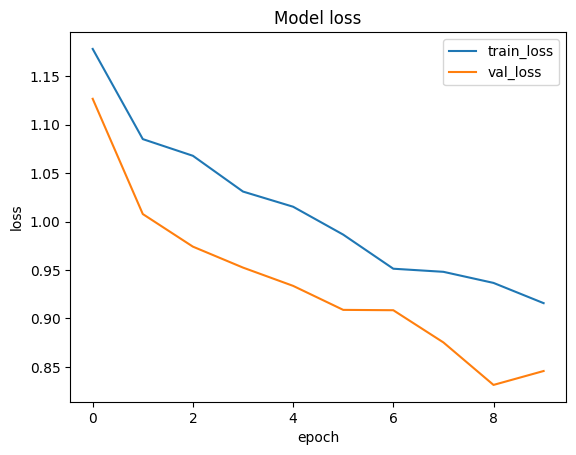

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper right')
plt.show()


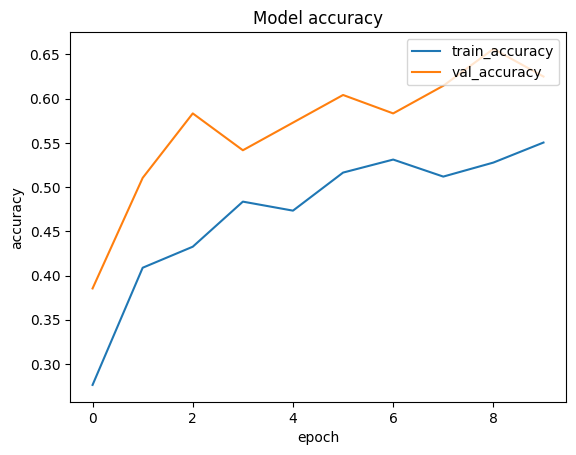

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'], loc='upper right')
plt.show()


In [23]:
# loading images and their predictions
from utils.heplers import test_model
from utils.globals import input_path
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

prediction, original, image = test_model(model, labels, input_path)


1/1 [==============================] - 0s 111ms/step


In [24]:
# Getting the test accuracy
score = accuracy_score(original, prediction)
print("Test Accuracy : {}".format(score))


Test Accuracy : 0.5478260869565217


In [25]:
# classification report
print(classification_report(np.asarray(original), np.asarray(prediction)))


                precision    recall  f1-score   support

Necrotic-Tumor       1.00      0.08      0.15        25
     Non-Tumor       0.51      0.96      0.66        51
        Viable       0.75      0.31      0.44        39

      accuracy                           0.55       115
     macro avg       0.75      0.45      0.42       115
  weighted avg       0.70      0.55      0.47       115



Text(0.5, 1.0, 'Confusion_matrix')

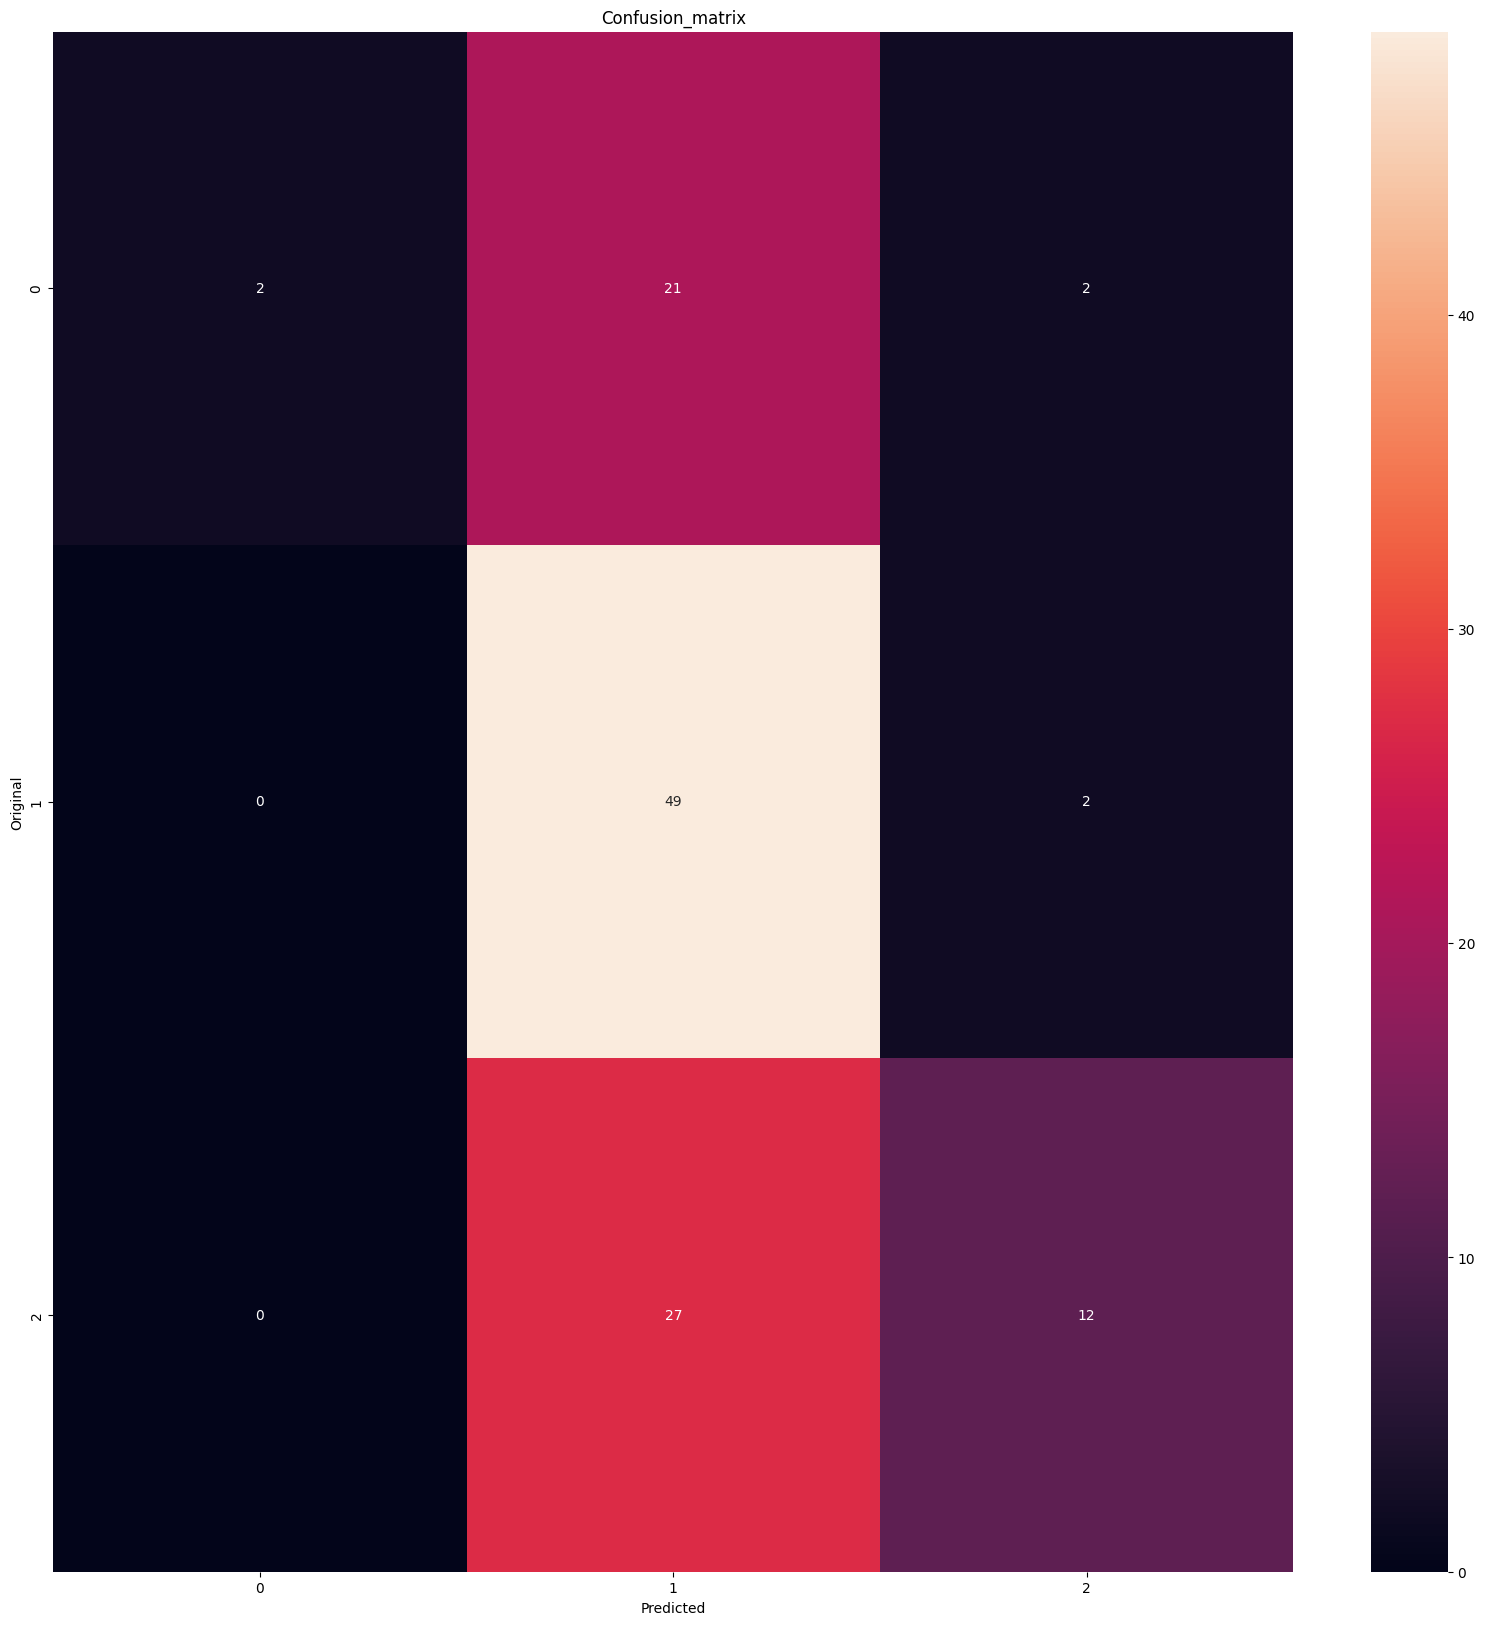

In [26]:
# plot confusion matrix
plt.figure(figsize=(20, 20))
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')


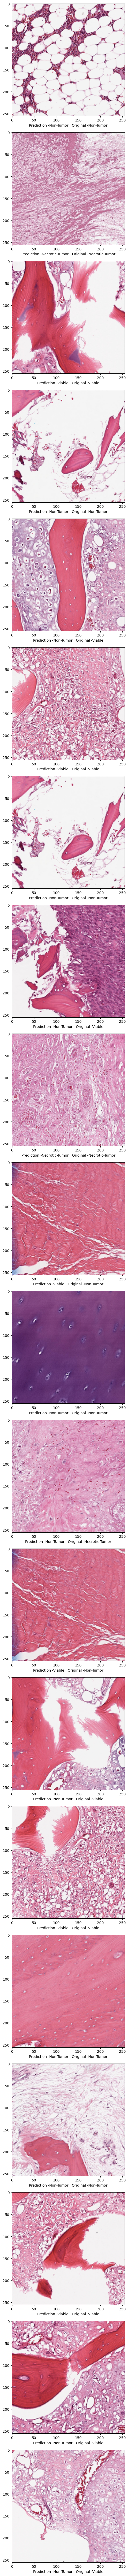

In [27]:
# visualizing the results
import random
fig = plt.figure(figsize=(100, 100))
for i in range(20):
    j = random.randint(0, len(image))
    fig.add_subplot(20, 1, i+1)
    plt.xlabel("Prediction -" + prediction[j] + "   Original -" + original[j])
    plt.imshow(image[j])
fig.tight_layout()
plt.show()
